In [1]:
import warnings
warnings.filterwarnings('ignore')


# <center>Mohamed Abbas</center>
### <center>mohamed_magdy92@live.com</center>

## 1. Introduction

Founded in 2008, Airbnb’s mission is to create a world where people can belong through healthy travel that is local, authentic, diverse, inclusive and sustainable. Airbnb uniquely leverages technology to economically empower millions of people around the world to unlock and monetize their spaces, passions and talents and become hospitality entrepreneurs. Airbnb’s accommodation marketplace provides access to 7 million unique places to stay in more than 100,000 cities and 191 countries and regions. With Experiences, Airbnb offers unprecedented access to local communities and interests through 40,000 unique, handcrafted activities run by hosts across 1,000+ cities around the world. Airbnb’s people-to-people platform benefits all our stakeholders, including hosts, guests, employees and the communities in which we operate.

## 2. Dataset

### Description of the Dataset
In this challenge, I am given a list of users along with their demographics, web session records, and some summary statistics. You are asked to predict which country a new user's first booking destination will be. All the users in this dataset are from the USA.

There are 12 possible outcomes of the destination country: 'US', 'FR', 'CA', 'GB', 'ES', 'IT', 'PT', 'NL','DE', 'AU', 'NDF' (no destination found), and 'other'. Please note that 'NDF' is different from 'other' because 'other' means there was a booking, but is to a country not included in the list, while 'NDF' means there wasn't a booking.

The training and test sets are split by dates. In the test set, you will predict all the new users with first activities after 7/1/2014 (note: this is updated on 12/5/15 when the competition restarted). In the sessions dataset, the data only dates back to 1/1/2014, while the users dataset dates back to 2010. 

### User Dataset

1. __train_users.csv__ - The training set of users
2. __test_users.csv__ - the test set of users

   - id: user id
   - date_account_created: the date of account creation
   - timestamp_first_active: timestamp of the first activity, note that it can be earlier than date_account_created or date_first_booking because a user can search before signing up
   - date_first_booking: date of first booking
   - gender
   - age
   - signup_method
   - signup_flow: the page a user came to signup up from
   - language: international language preference
   - affiliate_channel: what kind of paid marketing
   - affiliate_provider: where the marketing is e.g. google, craigslist, other
   - first_affiliate_tracked: whats the first marketing the user interacted with before the signing up
   - signup_app
   - first_device_type
   - first_browser
   - country_destination: this is the target variable you are to predict

### Session Dataset
1. __sessions.csv__ - web sessions log for users
  - user_id: to be joined with the column 'id' in users table
  - action
  - action_type
  - action_detail
  - device_type
  - secs_elapsed

### Countries Dataset
1. __countries.csv__ - Summary statistics of destination countries in this dataset and their locations
2. __age_gender_bkts.csv__ - Summary statistics of users' age group, gender, country of destination


# importing needed pacakges

In [2]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
import sys 
import os 
import folium
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score 
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier 
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error
import xgboost as xgb
from IPython.display import HTML, display
from sklearn.decomposition import PCA


## reading csv files

### removing "NDF" destination 

In [3]:
## loading training csv file for exploration and preprocessing 
train_df=pd.read_csv("airbnb/train_users_2.csv")  ## Training dataframe
train_df=train_df.loc[train_df.country_destination!="NDF"]

###  displaying data

In [4]:
display(train_df.head())

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
2,4ft3gnwmtx,2010-09-28,20090609231247,2010-08-02,FEMALE,56.0,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE,US
3,bjjt8pjhuk,2011-12-05,20091031060129,2012-09-08,FEMALE,42.0,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,other
4,87mebub9p4,2010-09-14,20091208061105,2010-02-18,-unknown-,41.0,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,US
5,osr2jwljor,2010-01-01,20100101215619,2010-01-02,-unknown-,NaN,basic,0,en,other,other,omg,Web,Mac Desktop,Chrome,US
6,lsw9q7uk0j,2010-01-02,20100102012558,2010-01-05,FEMALE,46.0,basic,0,en,other,craigslist,untracked,Web,Mac Desktop,Safari,US


### Replacing -unknown- values with nan
after displaying data i found that there is -unknown- values in the categorical variables that need to be replaced 

In [5]:
## replace unknown value with nan
train_df.replace('-unknown-', np.nan, inplace=True)

### Displaying datatypes 

In [6]:
display(train_df.dtypes)

id                          object
date_account_created        object
timestamp_first_active       int64
date_first_booking          object
gender                      object
age                        float64
signup_method               object
signup_flow                  int64
language                    object
affiliate_channel           object
affiliate_provider          object
first_affiliate_tracked     object
signup_app                  object
first_device_type           object
first_browser               object
country_destination         object
dtype: object

## Visualization  

### Age Visualization 

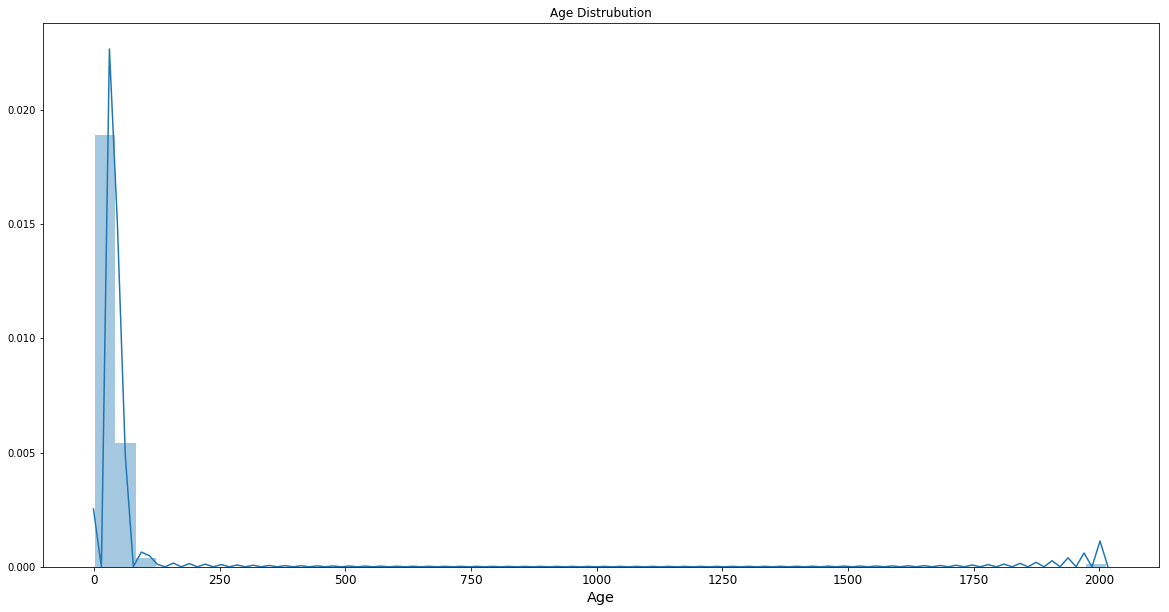

In [7]:
plt.figure(figsize=(20,10))
sns.distplot(train_df.age.dropna())
plt.xlabel("Age",fontsize="x-large")
plt.title("Age Distrubution")
plt.xticks(fontsize="large")
plt.savefig("output.png")
plt.show()

### Age data
after visualizing the age data i found that the age needs more adjustment before completing the visualization , so i started displaying more statitcs for the age and i found that the age min is 2 and max is 2014 which can't be true . 

In [8]:
display(train_df.age.describe())

count    68532.000000
mean        47.872629
std        146.042716
min          2.000000
25%         28.000000
50%         33.000000
75%         42.000000
max       2014.000000
Name: age, dtype: float64

we found some data that could be enterted by wrong year of birth instead of age this can be handeled easily
subtrut dates between 1915 and 1997 from 2015 age limit (18-100)
below 18 or over 100 replaced with nan

In [9]:
av=train_df.age.values
train_df['age'] = np.where(np.logical_and(av>1915, av<1997), 2015-av, av)
train_df['age'] = np.where(np.logical_or(av<18, av>100), np.nan, av)

distplot to get better look after age adjustment

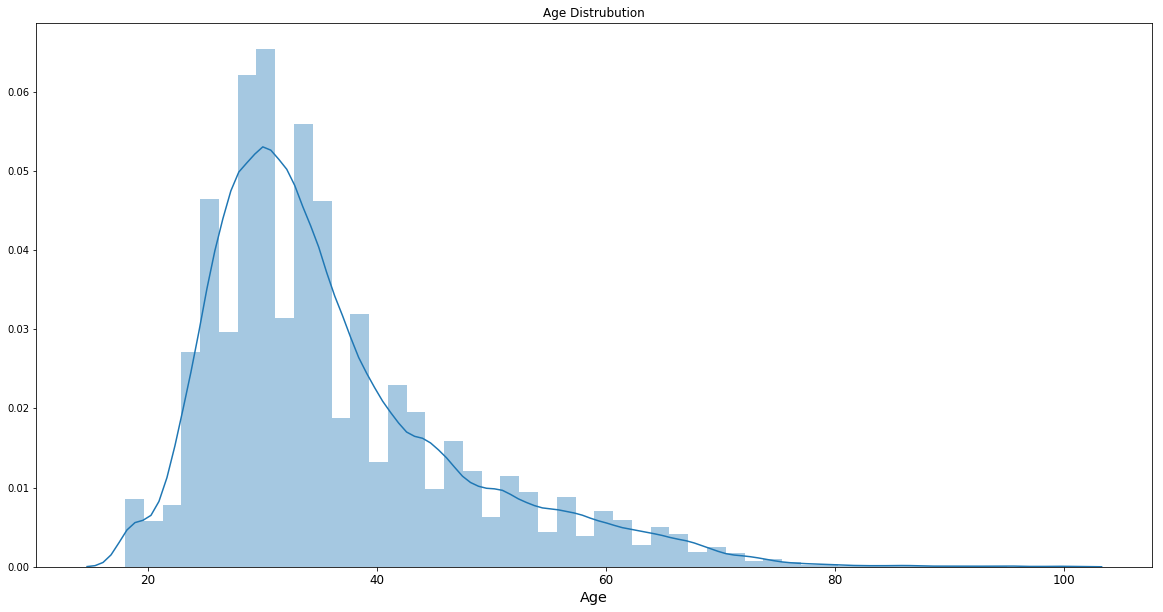

In [10]:
### some data visualiztion to get better look after age adjustment
plt.figure(figsize=(20,10))
sns.distplot(train_df.age.dropna())
plt.xlabel("Age",fontsize="x-large")
plt.title("Age Distrubution")
plt.xticks(fontsize="large")
plt.savefig("output1.png")
plt.show()

#### common age for travellers is between 20 and 45 

## Gender 

first we need to check the null values in gender and replace it with unknown

In [11]:
### now let's look about the Gender 
print(train_df.gender.isnull().sum())
train_df.gender=train_df.gender.fillna("unknown")

29018


Visualizing the data would give us better look to the ratio between genders 

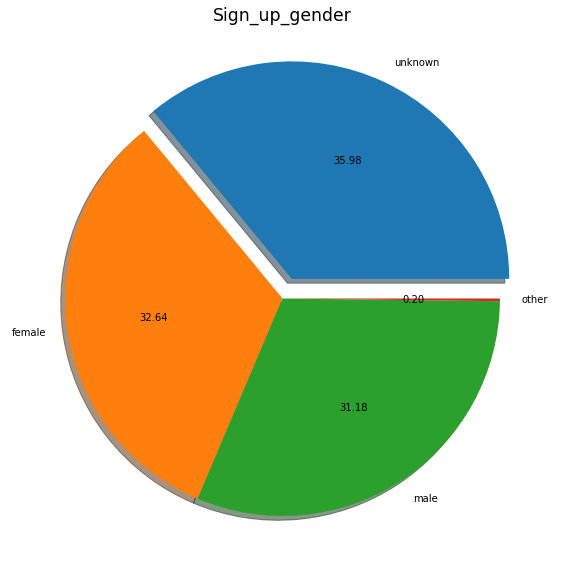

In [12]:
explode = (0.1, 0, 0,0)
plt.figure(figsize=(20,10))
plt.pie(x=train_df.gender.value_counts(),labels=("unknown","female","male","other"),autopct='%.2f',explode=explode,shadow=True)
plt.title("Sign_up_gender",fontsize="xx-large")
plt.savefig("Gender.png")
plt.show()


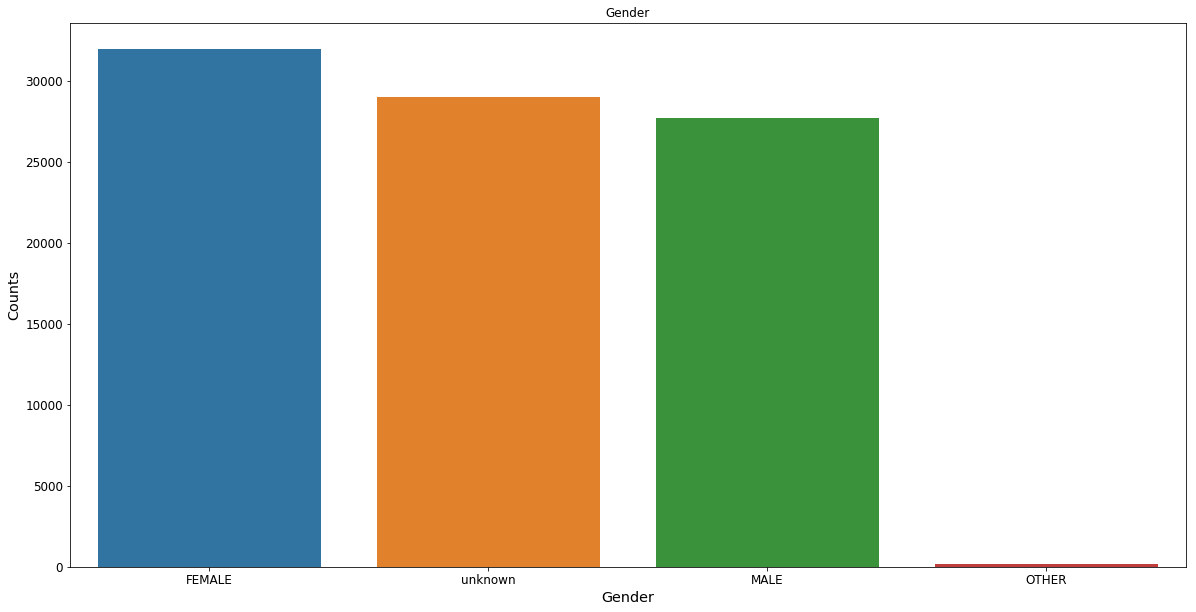

In [13]:
plt.figure(figsize=(20,10))
sns.countplot(x="gender",data=train_df)
plt.xlabel("Gender",fontsize="x-large")
plt.ylabel("Counts",fontsize="x-large")
plt.title("Gender")
plt.xticks(fontsize="large")
plt.yticks(fontsize="large")
plt.savefig("output2.png")
plt.show()

## Country

by plotting the country_destination i found that the most visited country is US

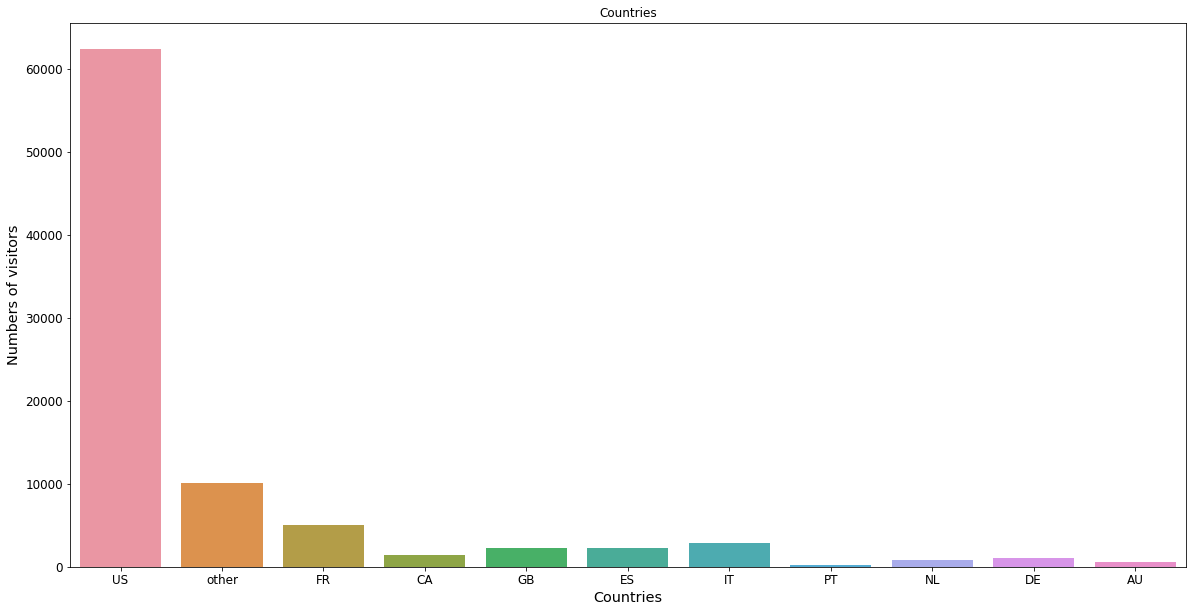

In [14]:
plt.figure(figsize=(20,10))
sns.countplot(x="country_destination",data=train_df)
plt.xlabel("Countries",fontsize="x-large")
plt.ylabel("Numbers of visitors",fontsize="x-large")
plt.title("Countries")
plt.xticks(fontsize="large")
plt.yticks(fontsize="large")
plt.savefig("output3.png")

## Checking country with Gender
now i will check the gender prefrence for country_destination 

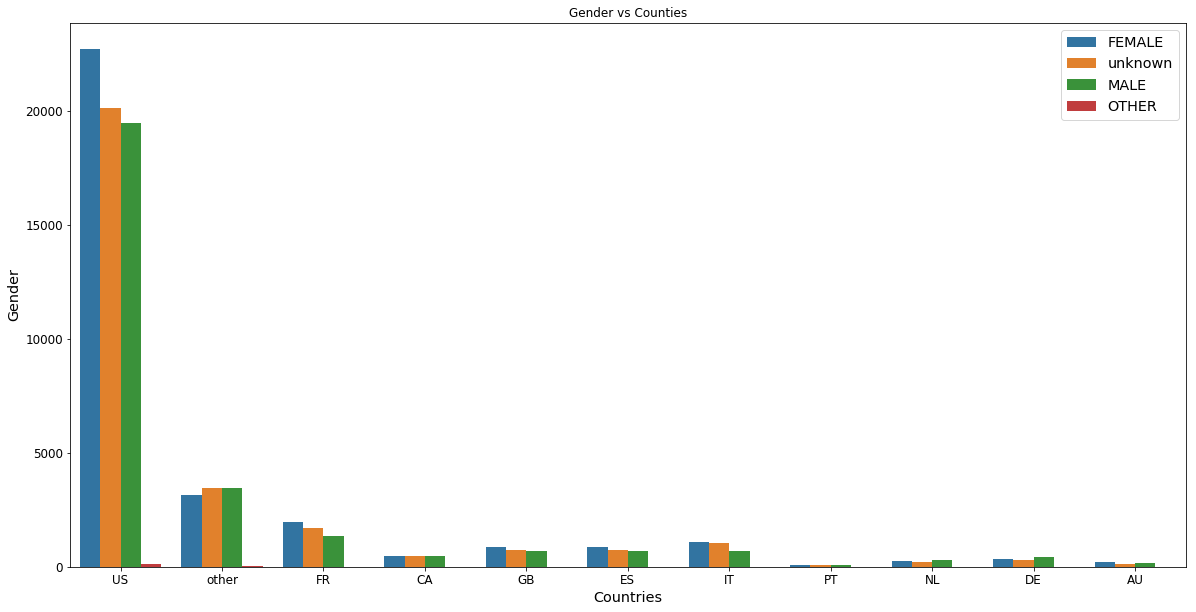

In [15]:
### check gender with countries 
plt.figure(figsize=(20,10))
sns.countplot(x="country_destination",data=train_df,hue="gender")
plt.xlabel("Countries",fontsize="x-large")
plt.ylabel("Gender",fontsize="x-large")
plt.title("Gender vs Counties")
plt.xticks(fontsize="large")
plt.yticks(fontsize="large")
plt.legend(fontsize="x-large")
plt.savefig("output4.png")


#### We can't have a specific prefered destination depending on the gender because as we see the ratios are so close

## Signup_app vs Country
Here we will try again to find relation between signup_app and the country_destination

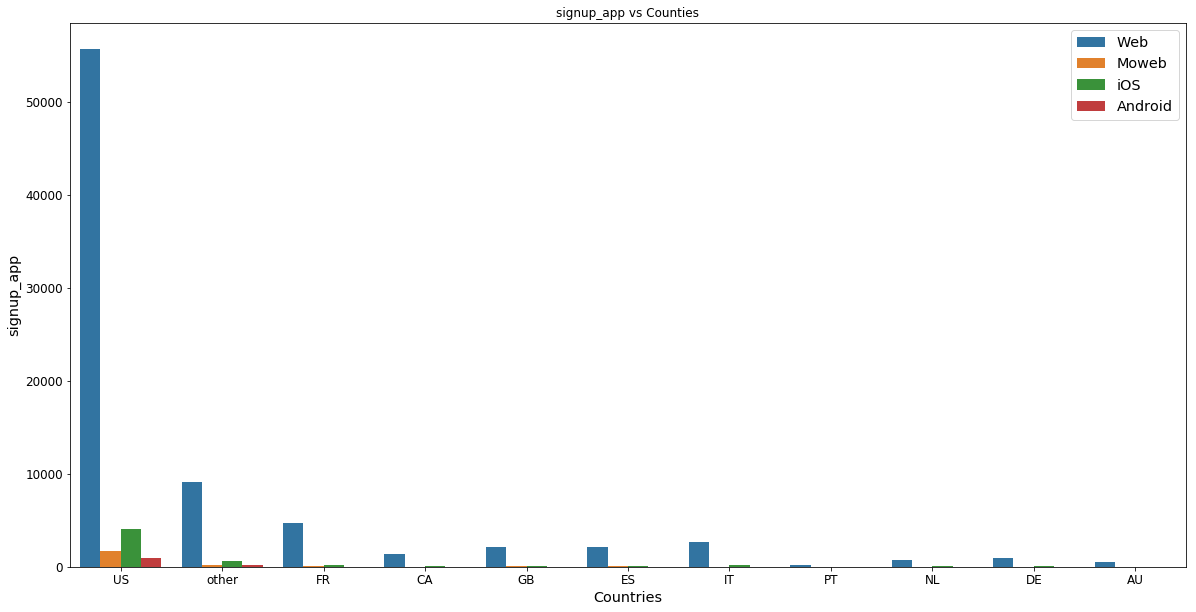

In [16]:
### check signup_app with countries 
plt.figure(figsize=(20,10))
sns.countplot(x="country_destination",data=train_df,hue="signup_app")
plt.xlabel("Countries",fontsize="x-large")
plt.ylabel("signup_app",fontsize="x-large")
plt.title("signup_app vs Counties")
plt.xticks(fontsize="large")
plt.yticks(fontsize="large")
plt.legend(fontsize="x-large")
plt.savefig("output6.png")


Again we can't find a relation between the Signup_app and the Country except that most of users prefer to signup throught web

### Age vs Signup_app vs Country


<Figure size 2160x1440 with 0 Axes>

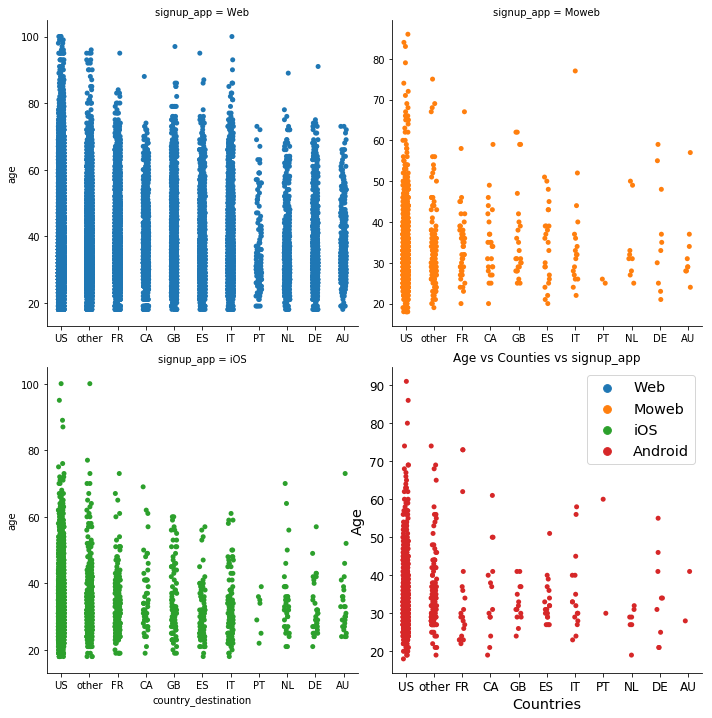

In [17]:
### check age with countries with signup_app 
plt.figure(figsize=(30,20))
sns.catplot(x="country_destination",y="age",data=train_df,hue="signup_app",kind="strip",ci=None,col="signup_app",col_wrap=2,sharex=False,sharey=False)
plt.xlabel("Countries",fontsize="x-large")
plt.ylabel("Age",fontsize="x-large")
plt.title("Age vs Counties vs signup_app")
plt.xticks(fontsize="large")
plt.yticks(fontsize="large")
plt.legend(fontsize="x-large")
plt.savefig("output5.png")


#### here we can find that most of users who are over 70 years old and using browser as there signup method tends more to visit US 

### Age vs gender vs Country 

<Figure size 2160x1440 with 0 Axes>

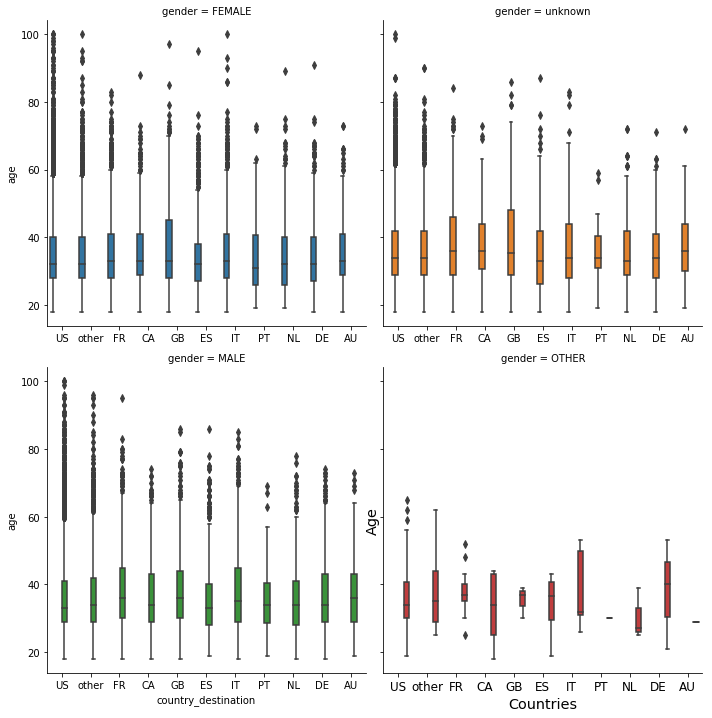

In [18]:
### check age with countries with gender 
plt.figure(figsize=(30,20))
sns.catplot(x="country_destination",y="age",data=train_df,hue="gender",kind="box",ci=None,col="gender",col_wrap=2,sharey=True,sharex=False)
plt.xlabel("Countries",fontsize="x-large")
plt.ylabel("Age",fontsize="x-large")
##plt.title("Age vs Counties vs gender")
plt.xticks(fontsize="large")
plt.yticks(fontsize="large")
##plt.legend(fontsize="x-large")
plt.savefig("output7.png")


##  Language

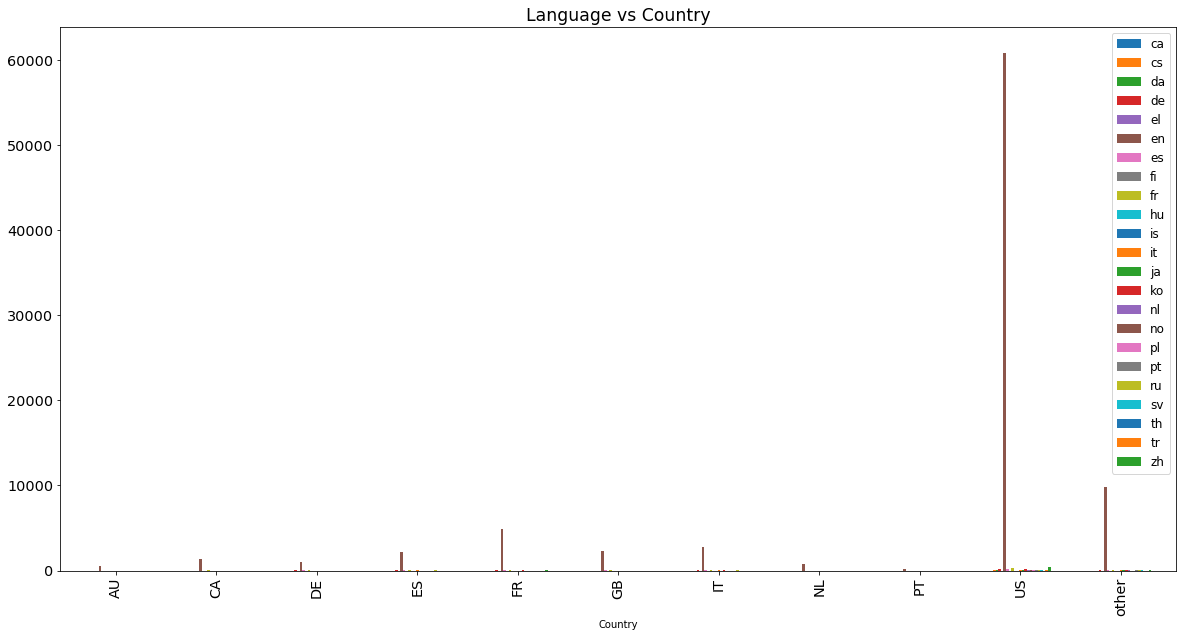

In [19]:
## language data 
lan =train_df.groupby(["country_destination","language"]).size()
lan.unstack().plot(kind='bar',figsize=(20,10),stacked=False,width=0.6)
plt.title("Language vs Country",fontsize="xx-large")
plt.xlabel("Country")
plt.xticks(fontsize="x-large")
plt.yticks(fontsize="x-large")
plt.legend(fontsize="large")
plt.savefig("output8.png")
plt.show()

after inspecting Language data we find that 98% prefer English as there language

## Age vs Country_destination

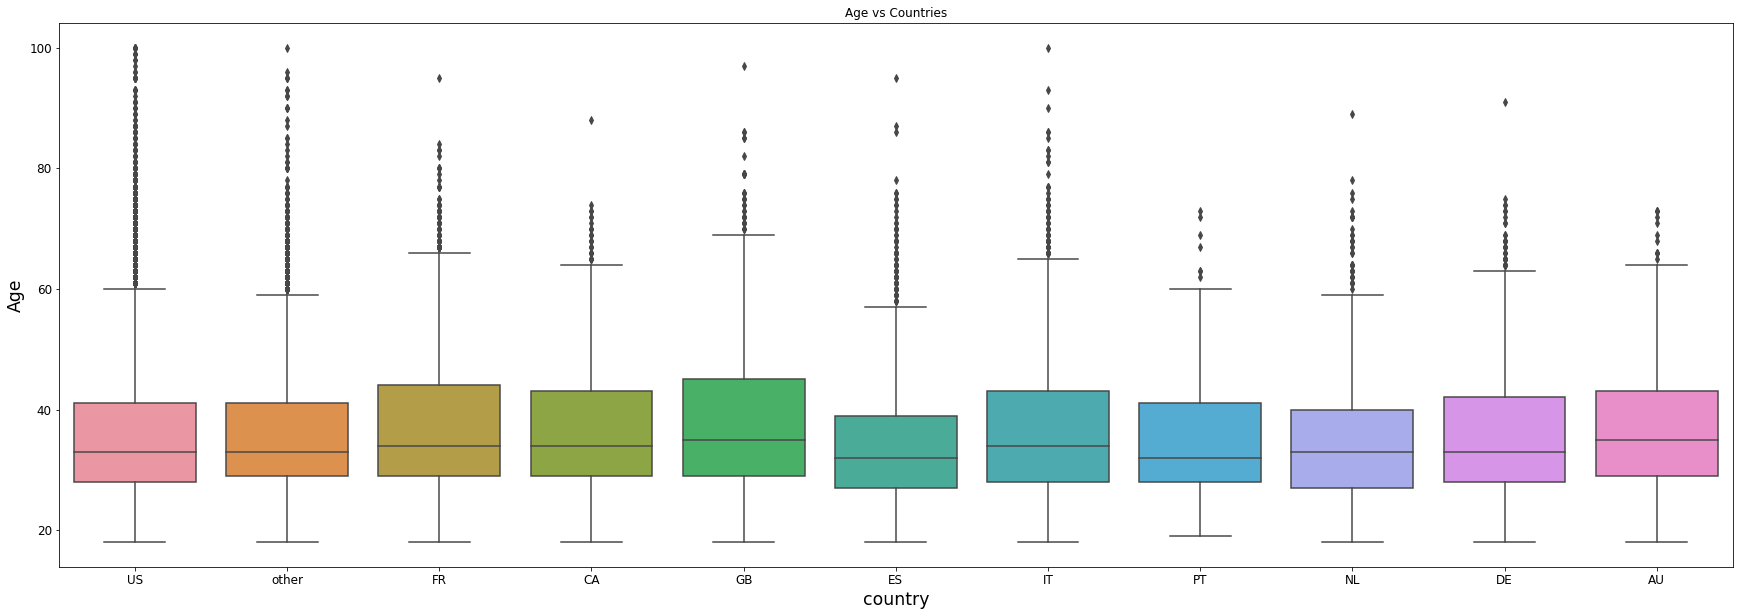

In [20]:
### check age with countries
plt.figure(figsize=(30,10))
sns.boxplot(x="country_destination",y="age",data=train_df)
plt.ylabel("Age",fontsize="xx-large")
plt.xlabel("country",fontsize="xx-large")
plt.title("Age vs Countries")
plt.xticks(fontsize="large")
plt.yticks(fontsize="large")
plt.savefig("output10.png")
plt.show()


#### after visualizing data we can get to know that older people prefer GB and younger prefer ES

## Signup_method vs Country_destination 

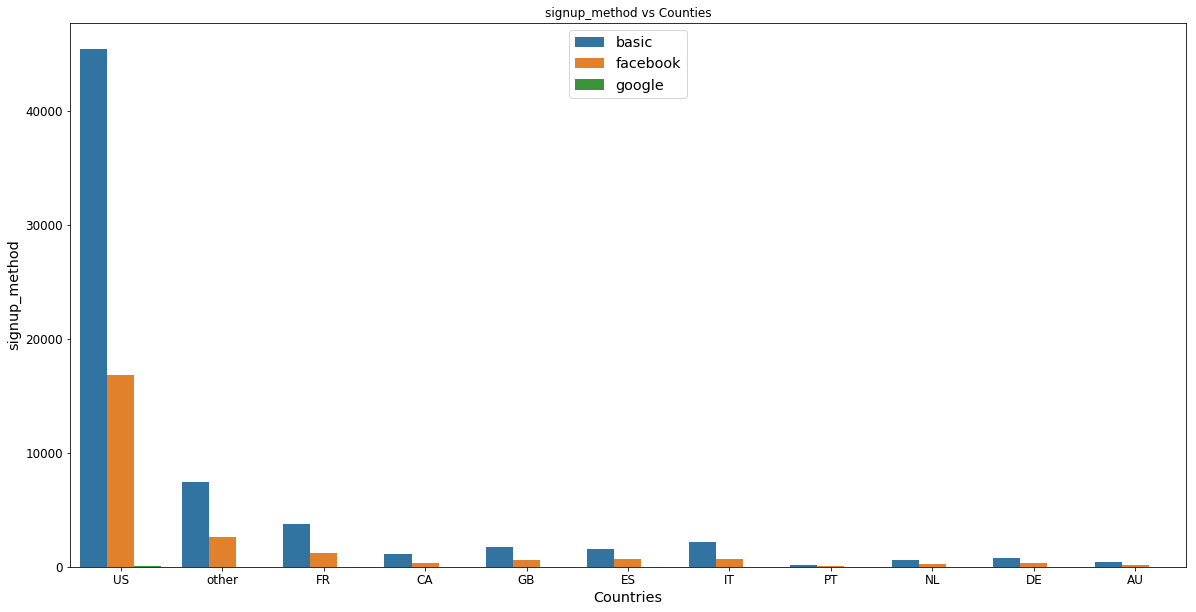

In [21]:
### check signup_method with countries 
plt.figure(figsize=(20,10))
sns.countplot(x="country_destination",data=train_df,hue="signup_method")
plt.xlabel("Countries",fontsize="x-large")
plt.ylabel("signup_method",fontsize="x-large")
plt.title("signup_method vs Counties")
plt.xticks(fontsize="large")
plt.yticks(fontsize="large")
plt.legend(fontsize="x-large")
plt.savefig("output11.png")


## Signup_method vs Country_destination  vs Age

<Figure size 2160x1440 with 0 Axes>

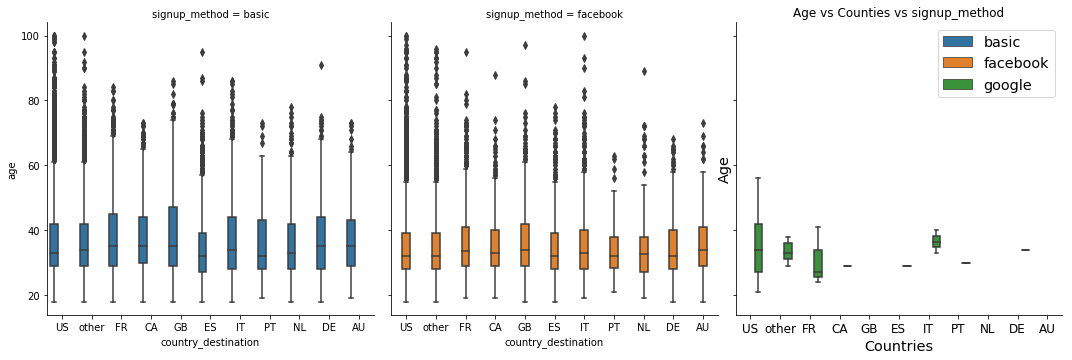

In [22]:
### check age with countries with signup_app 
plt.figure(figsize=(30,20))
sns.catplot(x="country_destination",y="age",data=train_df,hue="signup_method",kind="box",ci=None,col="signup_method",col_wrap=3,sharex=False,sharey=True)
plt.xlabel("Countries",fontsize="x-large")
plt.ylabel("Age",fontsize="x-large")
plt.title("Age vs Counties vs signup_method")
plt.xticks(fontsize="large")
plt.yticks(fontsize="large")
plt.legend(fontsize="x-large")
plt.savefig("output12.png")


#### people who use google as there signup_method tends more to book US

## first_device_type vs Country_destination vs Age 

<Figure size 2160x1440 with 0 Axes>

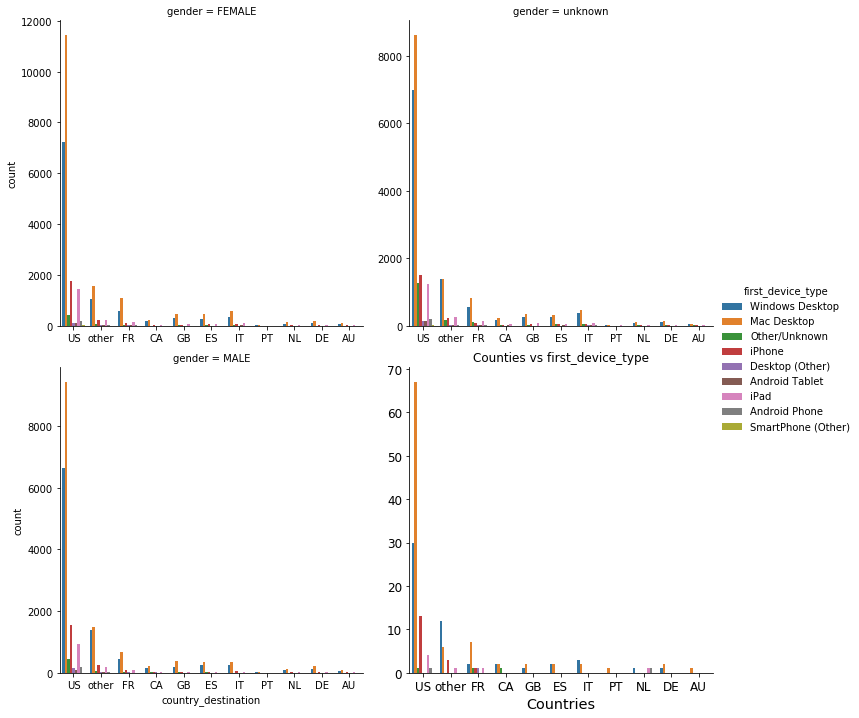

In [23]:
### check age with countries with first_device_type 
plt.figure(figsize=(30,20))
sns.catplot(x="country_destination",data=train_df,hue="first_device_type",kind="count",ci=None,col="gender",col_wrap=2,sharex=False,sharey=False)
plt.xlabel("Countries",fontsize="x-large")
plt.title("Counties vs first_device_type")
plt.xticks(fontsize="large")
plt.yticks(fontsize="large")
##plt.legend(fontsize="x-large")
plt.savefig("output13.png")


#### most users prefer using Mac Desktop

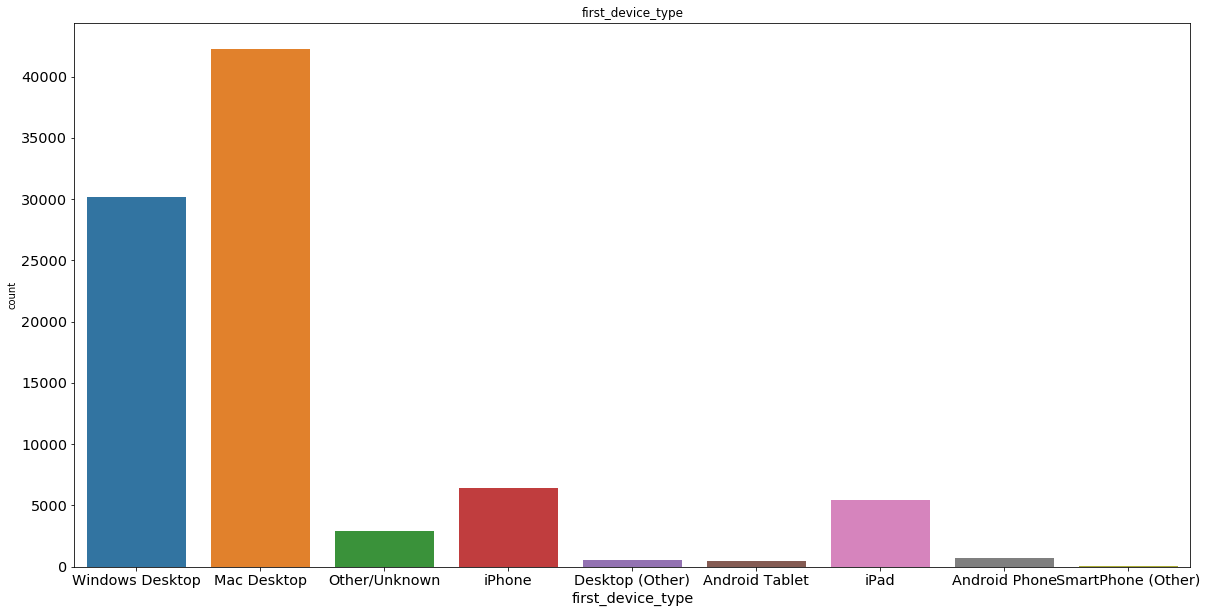

<Figure size 432x288 with 0 Axes>

In [24]:
### check age with countries with first_device_type 
plt.figure(figsize=(20,10))
sns.countplot(x="first_device_type",data=train_df)
plt.xlabel("first_device_type",fontsize="x-large")
plt.title("first_device_type")
plt.xticks(fontsize="x-large")
plt.yticks(fontsize="x-large")
plt.show()
plt.savefig("output14.png")

## Dates 


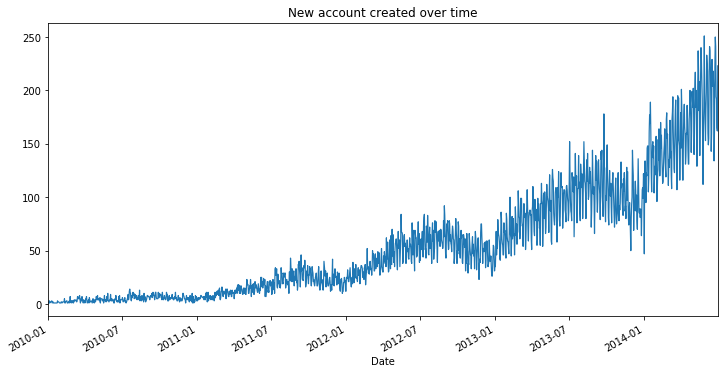

In [25]:
### dates
train_df['date_account_created'] = pd.to_datetime(train_df['date_account_created'])
train_df['timestamp_first_active'] = pd.to_datetime((train_df.timestamp_first_active)//1000000, format='%Y%m%d')
plt.figure(figsize=(12,6))
train_df.date_account_created.value_counts().plot(kind='line', linewidth=1.2)
plt.xlabel('Date')
plt.title('New account created over time')
plt.show()

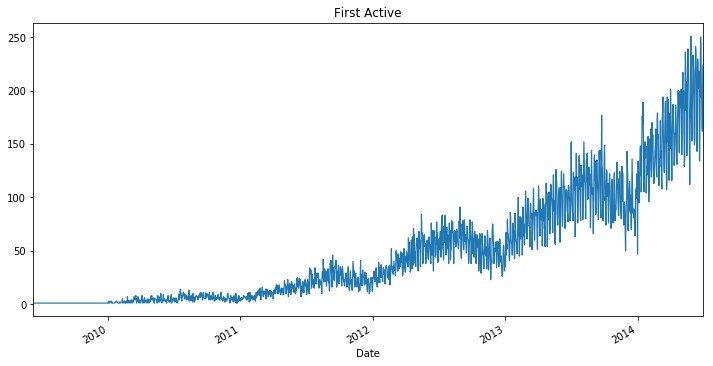

In [26]:
plt.figure(figsize=(12,6))
train_df.timestamp_first_active.value_counts().plot(kind='line', linewidth=1.2)
plt.xlabel('Date')
plt.title('First Active')
plt.show()

#### There is a huge jump in the number of signups and Active member after 2012

# Session 

In [27]:
## session 
session_df=pd.read_csv("airbnb/sessions.csv")   ## Session dataframe
print(session_df.head())

      user_id          action action_type        action_detail  \
0  d1mm9tcy42          lookup         NaN                  NaN   
1  d1mm9tcy42  search_results       click  view_search_results   
2  d1mm9tcy42          lookup         NaN                  NaN   
3  d1mm9tcy42  search_results       click  view_search_results   
4  d1mm9tcy42          lookup         NaN                  NaN   

       device_type  secs_elapsed  
0  Windows Desktop         319.0  
1  Windows Desktop       67753.0  
2  Windows Desktop         301.0  
3  Windows Desktop       22141.0  
4  Windows Desktop         435.0  


## Null Values

In [28]:
session_df.isnull().sum()

user_id            34496
action             79626
action_type      1126204
action_detail    1126204
device_type            0
secs_elapsed      136031
dtype: int64

### Replacing -unknown- values

In [29]:
## replae all -unknown- values with nan
session_df.replace("-unknown-",np.nan,inplace=True)

## Visualizing Device type 
as it's expected the mac device is the most common that users use in there sessions

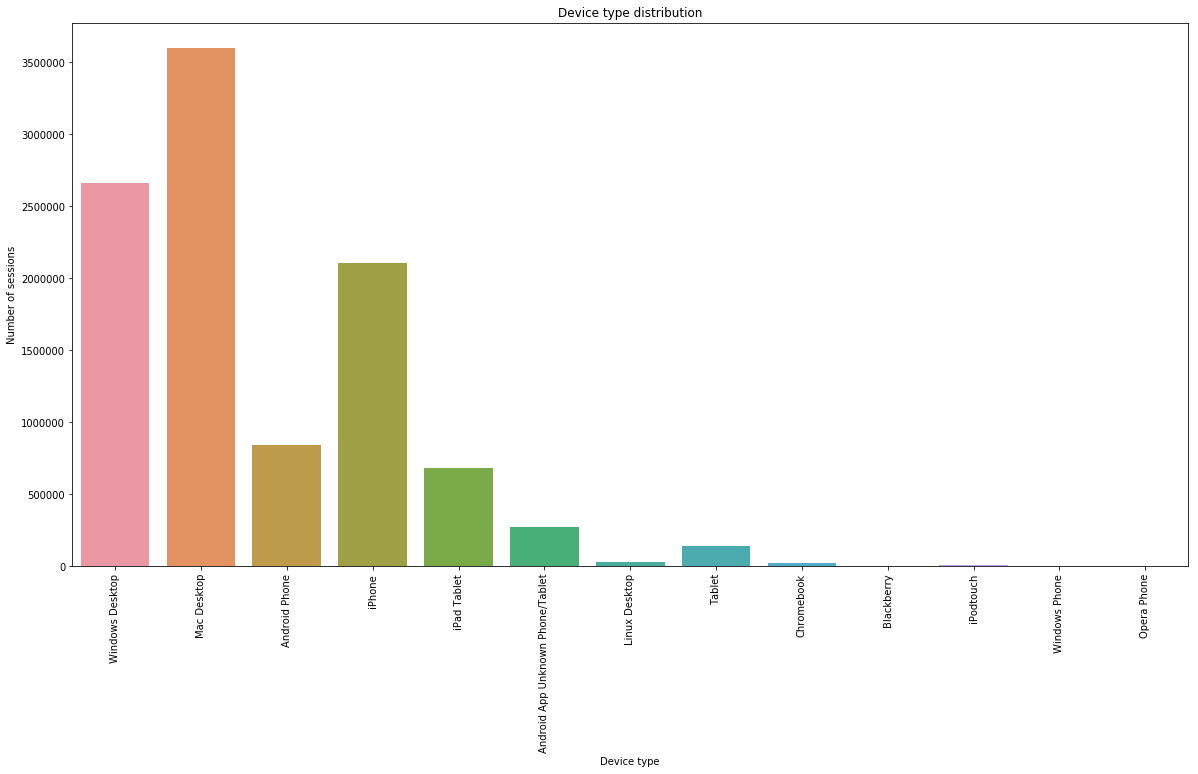

In [30]:
plt.figure(figsize=(20,10))
sns.countplot(x='device_type', data=session_df)
plt.xlabel('Device type')
plt.ylabel('Number of sessions')
plt.title('Device type distribution')
plt.xticks(rotation=90)
plt.show()

# Countries.csv

In [31]:
countries_df=pd.read_csv("airbnb/countries.csv")
all_df=pd.read_csv("airbnb/all.csv")

In [32]:
countries_df.head()

,country_destination,lat_destination,lng_destination,distance_km,destination_km2,destination_language,language_levenshtein_distance
0,AU,-26.853388,133.275160,15297.7440,7741220.0,eng,0.00
1,CA,62.393303,-96.818146,2828.1333,9984670.0,eng,0.00
2,DE,51.165707,10.452764,7879.5680,357022.0,deu,72.61
3,ES,39.896027,-2.487694,7730.7240,505370.0,spa,92.25
4,FR,46.232193,2.209667,7682.9450,643801.0,fra,92.06


Getting number of visits per country

In [33]:
list1=[]
for i in countries_df.country_destination : 
    list1.append(sum(train_df["country_destination"] == i ))
list2=[]
for i in countries_df.country_destination :
    for j in range(len(all_df["alpha-2"])): 
        if i == all_df["alpha-2"][j] :
            list2.append(all_df["alpha-3"][j])

In [34]:
#### change the value for US since it has most of visits 
list1[-1]=6000
countries_df["visit"]=list1
countries_df["code"]=list2


In [35]:
country_geo = 'airbnb/world-countries.json'
data_to_plot = countries_df[['code','visit']]

In [36]:
# Setup a folium map at a high-level zoom
map = folium.Map(location=[100, 100], zoom_start=0.5)

# choropleth maps bind Pandas Data Frames and json geometries.
#This allows us to quickly visualize data combinations
map.choropleth(geo_data=country_geo, data=data_to_plot,
             columns=['code','visit'],
             key_on='feature.id',
             fill_color='YlGnBu', fill_opacity=0.7, line_opacity=0.2,
             )

In [37]:
map.save('plot_data.html')

In [38]:
map

# Age_gender_bkts

In [39]:
age_gender_df=pd.read_csv("airbnb/age_gender_bkts.csv")

In [40]:
age_gender_df.head()

,age_bucket,country_destination,gender,population_in_thousands,year
0,100+,AU,male,1.0,2015.0
1,95-99,AU,male,9.0,2015.0
2,90-94,AU,male,47.0,2015.0
3,85-89,AU,male,118.0,2015.0
4,80-84,AU,male,199.0,2015.0


# Classification Model 
`

loading the datasets again

In [41]:
train_df = pd.read_csv('airbnb/train_users_2.csv')
test_df = pd.read_csv('airbnb/test_users.csv')
df = pd.concat((train_df, test_df), axis=0, ignore_index=True)
## dropping the date_first_booking since it's null in the test dataset
df.drop('date_first_booking', axis=1, inplace=True)

## Dealing with dates

### adding more features like (day,month,year,weekday) for both created and first_active

In [42]:
## converting types to datetime type
df['date_account_created'] = pd.to_datetime(df['date_account_created'])
df['timestamp_first_active'] = pd.to_datetime((df.timestamp_first_active // 1000000), format='%Y%m%d')
df['weekday_account_created'] = df.date_account_created.dt.weekday_name
df['day_account_created'] = df.date_account_created.dt.day
df['month_account_created'] = df.date_account_created.dt.month
df['year_account_created'] = df.date_account_created.dt.year
df['weekday_first_active'] = df.timestamp_first_active.dt.weekday_name
df['day_first_active'] = df.timestamp_first_active.dt.day
df['month_first_active'] = df.timestamp_first_active.dt.month
df['year_first_active'] = df.timestamp_first_active.dt.year

### Find the time diff between created and first_active 

In [43]:
df['time_lag'] = (df['date_account_created'] - df['timestamp_first_active'])
df['time_lag'] = df['time_lag'].dt.days
df.drop( ['date_account_created', 'timestamp_first_active'], axis=1, inplace=True)

after getting the difference between both times then convert it to days (int) then drop data_acount_created and timestamp_first_active since those can't be used in classifier (dates can't be used)

## Age column  

Airbnb rules is that min age for booking is 18 years old 

In [44]:
av=df.age.values
df['age'] = np.where(np.logical_and(av>1915, av<1997), 2015-av, av)
df['age'] = np.where(np.logical_or(av<18, av>100), np.nan, av)
df['age'].fillna(df['age'].mean(),inplace=True)

# Session Dataset 

In [45]:
sessions=pd.read_csv("airbnb/sessions.csv")
print(sessions.head())

      user_id          action action_type        action_detail  \
0  d1mm9tcy42          lookup         NaN                  NaN   
1  d1mm9tcy42  search_results       click  view_search_results   
2  d1mm9tcy42          lookup         NaN                  NaN   
3  d1mm9tcy42  search_results       click  view_search_results   
4  d1mm9tcy42          lookup         NaN                  NaN   

       device_type  secs_elapsed  
0  Windows Desktop         319.0  
1  Windows Desktop       67753.0  
2  Windows Desktop         301.0  
3  Windows Desktop       22141.0  
4  Windows Desktop         435.0  


#### we need to rename the user_id to id to match df 

In [46]:
sessions.rename(columns = {'user_id': 'id'}, inplace=True)

insted of multiple rows for each id we will groupby id and each variable and create a new dataframe

In [47]:
action_count = sessions.groupby(['id', 'action'])['secs_elapsed'].agg(len).unstack()
action_type_count = sessions.groupby(['id', 'action_type'])['secs_elapsed'].agg(len).unstack()
action_detail_count = sessions.groupby(['id', 'action_detail'])['secs_elapsed'].agg(len).unstack()
device_type_sum = sessions.groupby(['id', 'device_type'])['secs_elapsed'].agg(sum).unstack()

In [48]:
sessions_data = pd.concat([action_count, action_type_count, action_detail_count, device_type_sum],axis=1)
sessions_data.columns=sessions_data.columns.map(lambda x:str(x)+"_count")
sessions_data.index.names = ['id']

In [49]:
secs_elapsed = sessions.groupby('id')['secs_elapsed']
secs_elapsed = secs_elapsed.agg(
    {
        'secs_elapsed_sum': np.sum,
        'secs_elapsed_mean': np.mean,
        'secs_elapsed_min': np.min,
        'secs_elapsed_max': np.max,
        'secs_elapsed_median': np.median,
        'secs_elapsed_std': np.std,
        'secs_elapsed_var': np.var,
        'day_pauses': lambda x: (x > 86400).sum(),
        'long_pauses': lambda x: (x > 300000).sum(),
        'short_pauses': lambda x: (x < 3600).sum(),
        'session_length' : np.count_nonzero
    }
)
secs_elapsed.reset_index(inplace=True)
sessions_secs_elapsed = pd.merge(sessions_data, secs_elapsed, on='id', how='left')
df = pd.merge(df, sessions_secs_elapsed, on='id', how = 'left')


In [50]:
print(df.shape)
df=df.loc[:,~df.columns.duplicated()]
print(df.shape)

(275547, 571)
(275547, 529)


##  Encoding categorical data


In [51]:
categories = ['gender', 'signup_method', 'signup_flow', 'language','affiliate_channel', 'affiliate_provider', 'first_affiliate_tracked', 'signup_app', 'first_device_type', 'first_browser','weekday_account_created', 'weekday_first_active']
df = pd.get_dummies(df, columns=categories)

## Splitting back the train and test data

In [52]:
df.set_index('id', inplace=True)
train_df1 = df.loc[train_df['id']]
test_df1 = df.loc[test_df['id']].drop('country_destination', axis=1)
train_df1.reset_index(inplace=True)
test_df1.reset_index(inplace=True)
train_df1.fillna(-1, inplace=True)
test_df1.fillna(-1, inplace=True)


## Label encoding 

In [53]:
y = train_df1['country_destination']
train_df1.drop(['country_destination','id'], axis=1, inplace=True)
x = train_df1.values
label_encoder = LabelEncoder()
encoded_y_train = label_encoder.fit_transform(y)

## Model 

In [54]:
x_train,x_test,y_train,y_test=train_test_split(x,encoded_y_train,test_size=0.2)    
sc_x = StandardScaler() 
x_train = sc_x.fit_transform(x_train)  
x_test = sc_x.transform(x_test)


In [55]:
pca=PCA()
x_transform=pca.fit_transform(x_train)
x_test_transform=pca.transform(x_test)

In [61]:
models=[RandomForestClassifier(),DecisionTreeClassifier()]
for model in models : 
    print(model)
    model.fit(x_transform,y_train)
    print("Model Trained")
    y_pred=model.predict(x_test)
    print ("Accuracy : ", accuracy_score(y_test, y_pred)) 
    

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
Model Trained
Accuracy :  0.5742896629266122
DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')
Model Trained
Accuracy :  0.1407322386451477


In [57]:
xboost_train=xgb.DMatrix(data=x_transform,label=y_train)
param={"max_depth":2,"seed":42,"learning_rate":1,"n_estimator":5,"objective":"multi:softmax","num_class":12,"nthread":4,"gamma":0,"min_child_weight":1,"colsamole_bytree":1,"colsample_bylevel":1 }
rounds=3
boost=xgb.train(param,xboost_train,rounds)

In [58]:
y_pred=boost.predict(xgb.DMatrix(x_test))

In [59]:
print ("Accuracy : ", accuracy_score(y_test, y_pred))

Accuracy :  0.5819025087254925


#   

# Result  

In [69]:
final=sc_x.transform(test_df1.drop("id",axis=1))
final=pca.transform(final)
y_predict=boost.predict(xgb.DMatrix(final))
results=label_encoder.inverse_transform(y_predict.astype("int32"))

C:\Users\Mohamed\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  """Entry point for launching an IPython kernel.


In [72]:
submission=pd.DataFrame()
submission["id"]=test_df["id"]
submission["country_destination"]=results
submission.to_csv(r"submission.csv")